### Image Classification

__Goal is to train a deep convolutional Neural Network to classify images into one of two classes: Red and Blue Car__

In [4]:
# Importing Dependencies 
import numpy as np 
import pandas as pd 
import os 
import matplotlib.pyplot as plt 
%matplotlib inline
import tensorflow as tf
import cv2
import imghdr

In [5]:
# Avoiding Out-Of-Memory error by setting memory growth 

# Listing the number of physical gpus 
gpus = tf.config.experimental.list_physical_devices('gpu')

# Limiting the memory growth 
for gpu in gpus: 
    tf.config.experimental.set_memory_growth('gpu', True)

In [39]:
# Removing bad images from our data 
data_dir = 'mydata'

# Setting up the extension list 
ext = ['jpeg', 'jpg', 'bmp', 'png']

# Checks any incorrect images and abnormal extensions and removes 
for image_class in os.listdir(data_dir):
    for image in os.listdir(os.path.join(data_dir, image_class)):
        image_path = os.path.join(data_dir, image_class, image)
        img = cv2.imread(image_path)
        #tip = imghdr.what(image_path)
        #if tip not in ext: 
        #    print('Image extension not in list {}'.format(image_path))
        #    os.remove(image_path)

In [7]:
for image_class in os.listdir(data_dir):
    print(image_class)

Blue Car
Red Car


In [8]:
# Labelling our dataset and creating batches 
data =tf.keras.preprocessing.image_dataset_from_directory('mydata',
  batch_size = 20,
  image_size = (140,140),
)

Found 259 files belonging to 2 classes.


In [9]:
# Creating an iterator to iterate through the batch 
data_iterator = data.as_numpy_iterator()
data_iterator.next()[1]

array([0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0])

In [10]:
# Creating the batch 
batch = data_iterator.next()

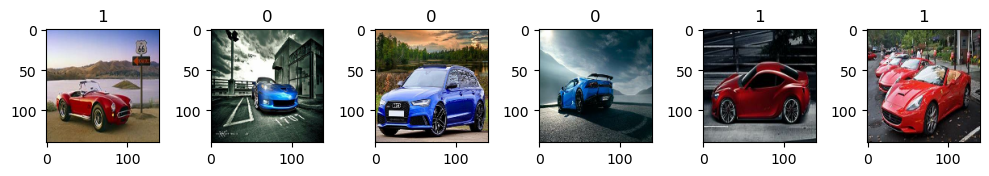

In [11]:
# Visualising the batch to determine the class assignment by the image_dataset_from_directory

# Viewing first 4 images 
fig, axes = plt.subplots(ncols=6, figsize = (10,10))
for ind, img in enumerate(batch[0][:6]):
    axes[ind].imshow(img.astype(int))
    axes[ind].title.set_text(batch[1][ind])
    
plt.tight_layout()

 __Preprocessing__ 

In [12]:
# Scaling within the data pipeline
data = data.map(lambda x,y: (x / 255, y))
# Scaling only the images 

In [13]:
# Splitting the model into train, test, validation 
# Specifying the sizes
train_size = int(len(data)*0.7)
val_size = int(len(data)*0.2)
test_size = int(len(data)*0.1)

In [14]:
# Creating the train, test, validation sets 
train = data.take(train_size)
test = data.skip(train_size).take(test_size)
validation = data.skip(train_size+test_size).take(val_size)
train

<TakeDataset shapes: ((None, 140, 140, 3), (None,)), types: (tf.float32, tf.int32)>

__Modelling__

In [15]:
# Building a deep convolutional Neural Network 

# Installing dependencies 
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, MaxPooling2D, Conv2D, Dropout

In [16]:
# Shape/dimension of the training dataset 
train

<TakeDataset shapes: ((None, 140, 140, 3), (None,)), types: (tf.float32, tf.int32)>

In [17]:
# Creating model 
model = Sequential()

# input layer
model.add(Conv2D(16, (3,3), 1, input_shape = (140,140,3), activation = 'relu'))


# Hidden Layers 
model.add(Conv2D(32, (3,3), 1, activation = 'relu'))
model.add(MaxPooling2D())

model.add(Conv2D(64, (3,3), 1, activation = 'relu'))
model.add(MaxPooling2D())

model.add(Conv2D(32, (3,3), 1, activation = 'relu'))
model.add(MaxPooling2D())

model.add(Conv2D(32, (3,3), 1, activation = 'relu'))
model.add(MaxPooling2D())

model.add(Conv2D(16, (3,3), 1, activation = 'relu'))
model.add(MaxPooling2D())

model.add(Flatten()) # Converting to 1-D

model.add(Dense(140, activation = 'relu'))
model.add(Dropout(0.2))

model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='adam', loss = tf.losses.BinaryCrossentropy(), metrics = ['accuracy'])

In [18]:
# Viewing the model summary
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 138, 138, 16)      448       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 136, 136, 32)      4640      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 68, 68, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 66, 66, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 33, 33, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 31, 31, 32)        18464     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 15, 15, 32)        0

In [19]:
# Import Tensorboard and Early Stopping 
from tensorflow.keras.callbacks import TensorBoard, EarlyStopping
from datetime import datetime
ea_stop = EarlyStopping(monitor='val_loss', mode = 'min', patience=30)
log_directory = 'logs\\'+ datetime.now().strftime('%M%H%S')

tensorflow_callback = TensorBoard(log_dir=log_directory, 
                   histogram_freq=1, 
                   write_graph = True, 
                   write_images = True, 
                   update_freq = 'epoch')

In [24]:
model.fit(train, epochs=10, validation_data=validation, callbacks=[tensorflow_callback , ea_stop])

Epoch 1/10
9/9 [==============================] - 3s 301ms/step - loss: 0.0028 - accuracy: 1.0000 - val_loss: 0.0080 - val_accuracy: 1.0000
Epoch 2/10
9/9 [==============================] - 3s 283ms/step - loss: 0.0039 - accuracy: 1.0000 - val_loss: 4.4491e-05 - val_accuracy: 1.0000
Epoch 3/10
9/9 [==============================] - 3s 296ms/step - loss: 0.0157 - accuracy: 0.9944 - val_loss: 0.0335 - val_accuracy: 0.9750
Epoch 4/10
9/9 [==============================] - 2s 272ms/step - loss: 0.2170 - accuracy: 0.9667 - val_loss: 0.1159 - val_accuracy: 0.9500
Epoch 5/10
9/9 [==============================] - 3s 292ms/step - loss: 0.0064 - accuracy: 0.9944 - val_loss: 0.0018 - val_accuracy: 1.0000
Epoch 6/10
9/9 [==============================] - 3s 381ms/step - loss: 0.0036 - accuracy: 1.0000 - val_loss: 0.0075 - val_accuracy: 1.0000
Epoch 7/10
9/9 [==============================] - 3s 325ms/step - loss: 0.0044 - accuracy: 1.0000 - val_loss: 9.4494e-04 - val_accuracy: 1.0000
Epoch 8/10
9

Using Tensorboard to analyse results

In [25]:
print(log_directory)

logs\530739


In [26]:
pwd

'C:\\Users\\jacks\\Documents\\Other Training\\Neural Network\\Image Classification'

__Evaluation__

<AxesSubplot: >

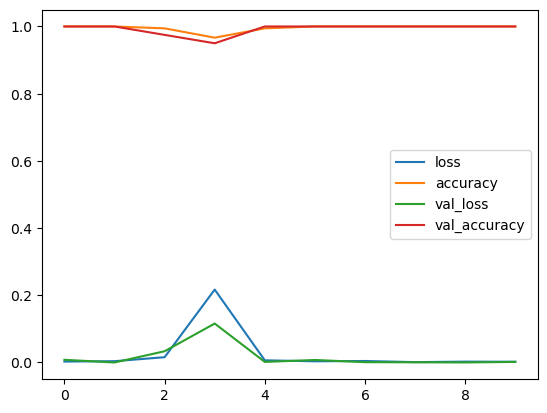

In [27]:
# Plotting the losses for training and validation
pd.DataFrame(model.history.history).plot()

In [28]:
# Creating interactive visualisation for losses 
import cufflinks as cf
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)
cf.go_offline()

In [29]:
# Evaluation of the model using iplot
pd.DataFrame(model.history.history).iplot()

In [31]:
# Using Accuracy, Precision & Recall to evaluate model performance 
from keras.metrics import Recall, Precision

pre = Precision()
re = Recall()

for batch in test.as_numpy_iterator():
    X, y = batch
    y_hat = model.predict(X)
    pre.update_state(y_hat, y)
    re.update_state(y_hat, y)

In [32]:
# Showing the metrics
print('Precision =', pre.result().numpy())
print('Recall =', re.result().numpy())

Precision = 1.0
Recall = 0.65


#### This is not a great precision - more work is needed to increase precision (maybe rebalance the dataset)

__Saving the Model__

In [33]:
# Saving 
from keras.models import load_model


current_time = datetime.now().strftime('%M%H%S')
model.save(os.path.join('Model', 'firstmodel'+current_time))

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: Model\firstmodel550713\assets


In [34]:
# Loading 
model = load_model(os.path.join('model', 'firstmodel'+current_time))

In [35]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 138, 138, 16)      448       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 136, 136, 32)      4640      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 68, 68, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 66, 66, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 33, 33, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 31, 31, 32)        18464     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 15, 15, 32)        0

In [62]:
# Upload a new image (unseen)
img = cv2.imread('blue mini.jpg')

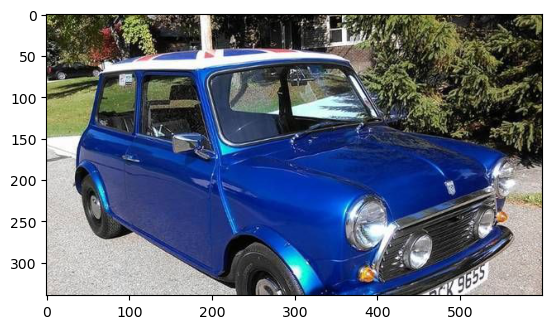

In [63]:
# Showing the image 
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.show()

In [64]:
# Resizing the image before shown to model 

# Input layer of neural network has input shape of (140,140,3)
resize = tf.image.resize(img, (140,140))

In [65]:
# Expanding the dimensions of the image and scaling 
img = np.expand_dims(resize/255,0)
img.shape

(1, 140, 140, 3)

In [71]:
# Using the model to predict the color of the new car
y_hat = model.predict(img)
y_hat = y_hat[0][0]

if y_hat > 0.5:
    print('Image is a blue car')
else:
    print('Image is a red car')

Image is a blue car


In [72]:
# Predicting a red car 
img = cv2.imread('Red mini.jpg')

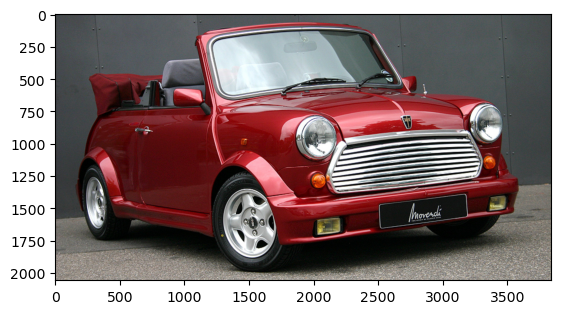

In [74]:
# Showing image 
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.show()

In [75]:
# Resizeing, scaling and increasing dimensions 

# Resizing 
resize = tf.image.resize(img, (140,140))

img = np.expand_dims(resize/255, 0)

In [78]:
y_hat = model.predict(img)[0]
if y_hat > 0.5: 
    print('Image is a blue car')
else:
    print('Image is a red car')

Image is a red car
